In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.io
import mat73
from sklearn.decomposition import PCA
from math import sqrt
from scipy import stats
import SVARIV
import missingno as msno
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
import statsmodels.formula.api as smf
from statistics import NormalDist
import LP
# Setting options
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")

# Other imports
from pylab import rcParams
from PIL import Image
from tqdm import tqdm
import io
import random

# Center function
center_function = lambda x: x - x.mean()

# Formatter function
def formatter(x, pos):
    del pos
    return round(x * 100, 1)


In [2]:
def split_into_close_integers(n):
    best_pair = None
    min_difference = float('inf')

    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            # i and n//i are factors of n
            difference = abs(i - n // i)
            if difference < min_difference:
                min_difference = difference
                best_pair = [i, n // i]

    # If n is a prime number, return [n, 1]
    return best_pair if best_pair else [n, 1]


In [3]:
# Data for check of correctness of our futher ALL table 
data = pd.read_excel('./Main_Data/oilSupplyNewsShocks_2023M06.xlsx', sheet_name="Monthly", index_col=0, na_values=0)

# Rename columns
data.rename(columns={"Oil supply surprise series": "OSSS", "Oil supply news shock": "OSNS"}, inplace=True)

# Drop NaN values in the 'OSSS' column
data1 = data['OSSS'].dropna()


In [4]:
# Load data from mat files
OSML = mat73.loadmat('./Main_Data/OilSurprisesMLog.mat')
ODM = scipy.io.loadmat('./Main_Data/OilDataM.mat')
OSMLC = scipy.io.loadmat('./Main_Data/OilSurprisesMLogControl.mat')
DBM = scipy.io.loadmat('./Main_Data/dataBaseM.mat')

# Convert dictionary to DataFrame
A1 = pd.DataFrame.from_dict(OSML.items()).T
A1.columns = A1.iloc[0]
new_df = A1.iloc[1:].reset_index(drop=True)

In [5]:
# Load data from Excel file
df = pd.read_excel("./Main_Data/Oilfutures.xlsx", sheet_name="POIL", index_col=0, header=1)

# Calculate percentage difference and fill NaN values with 0
diff = 100 * np.log(df).diff()
diff = diff.iloc[:, 1:13].fillna(0)

# Perform PCA on the z-scored data
pca_result = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(diff))
df['pca_comp_1'] = - pca_result[:, 0] / np.std(pca_result[:, 0]) ** (1 / 2)

# Assuming you have a DataFrame named OPECplacebos with 'OPEC trading day' and 'Placebo date' columns
opec_trading_days = pd.read_excel("./Main_Data/OPECplacebos.xlsx")['OPEC trading day'].dropna().values
placebo_dates = pd.read_excel("./Main_Data/OPECplacebos.xlsx")['Placebo date'].dropna().values

# Filter data based on OPEC trading days and Placebo dates
OTDdata = diff[diff.index.isin(opec_trading_days)]
PDdata = diff[diff.index.isin(placebo_dates)]

# Include pca_comp_1 in the grouped DataFrames
OTDdata['pca_comp_1'] = df['pca_comp_1']
PDdata['pca_comp_1'] = df['pca_comp_1']

# Group by month and sum the values
OTDdata1= OTDdata.groupby(OTDdata.index.to_period('M')).agg('sum')
OTDdata1.index = OTDdata1.index.to_timestamp()

PDdata1 = PDdata.groupby(PDdata.index.to_period('M')).agg('sum')
PDdata1.index = PDdata1.index.to_timestamp()

# Display the result
result = pd.concat([OTDdata1, PDdata1], axis=1)


28.11.2014 insted of  27.11.2014 must be an OPEC announcement date



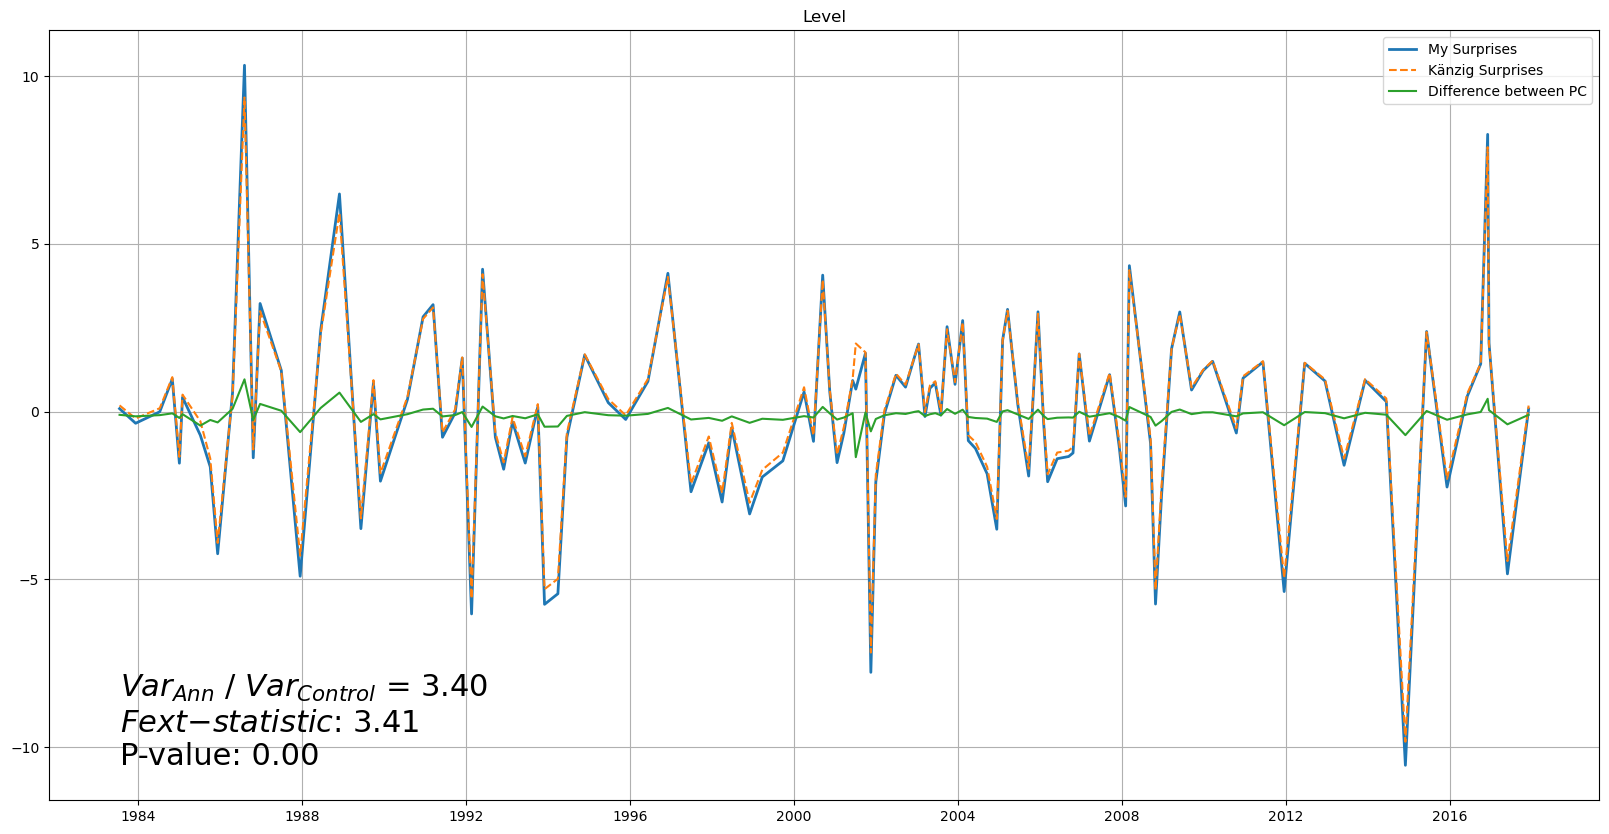

In [6]:
# Function to calculate F-statistic
def f_statistic_calculation(series1, series2):
    variance1 = np.var(series1, ddof=1)
    variance2 = np.var(series2, ddof=1)

    # Calculate the F-statistic
    f_value = variance1 / variance2

    # Calculate the degrees of freedom
    df1 = len(series1) - 1
    df2 = len(series2) - 1

    # Calculate the p-value
    p_value = 1 - stats.f.cdf(f_value, df1, df2)

    return f_value, p_value

# Calculate variance ratio and F-statistic
f_value, p_value = f_statistic_calculation(OTDdata.pca_comp_1.values, PDdata.pca_comp_1.values)
var_ratio = np.var(OTDdata.pca_comp_1.values) / np.var(PDdata.pca_comp_1.values)

# Plotting
rcParams['figure.figsize'] = 20, 10

plt.text(OTDdata.index.min(), OTDdata.pca_comp_1.min(), 
         f'$Var_{{Ann}}$ / $Var_{{Control}}$ = {var_ratio:.2f}\n$F\text{{-statistic}}$: {f_value:.2f}\nP-value: {p_value:.2f}', 
         fontsize=22)

plt.plot(OTDdata.pca_comp_1, label='My Surprises', linewidth=2)
plt.plot(OTDdata.index, data1[:117].values, label='Känzig Surprises', linestyle='dashed')
plt.plot(OTDdata.index, OTDdata.pca_comp_1.values - data1.values[:117], label='Difference between PC')

plt.title("Level")
plt.grid()
plt.legend()
plt.show()


Probability of x > 1 for Announcement KDE: 0.3378


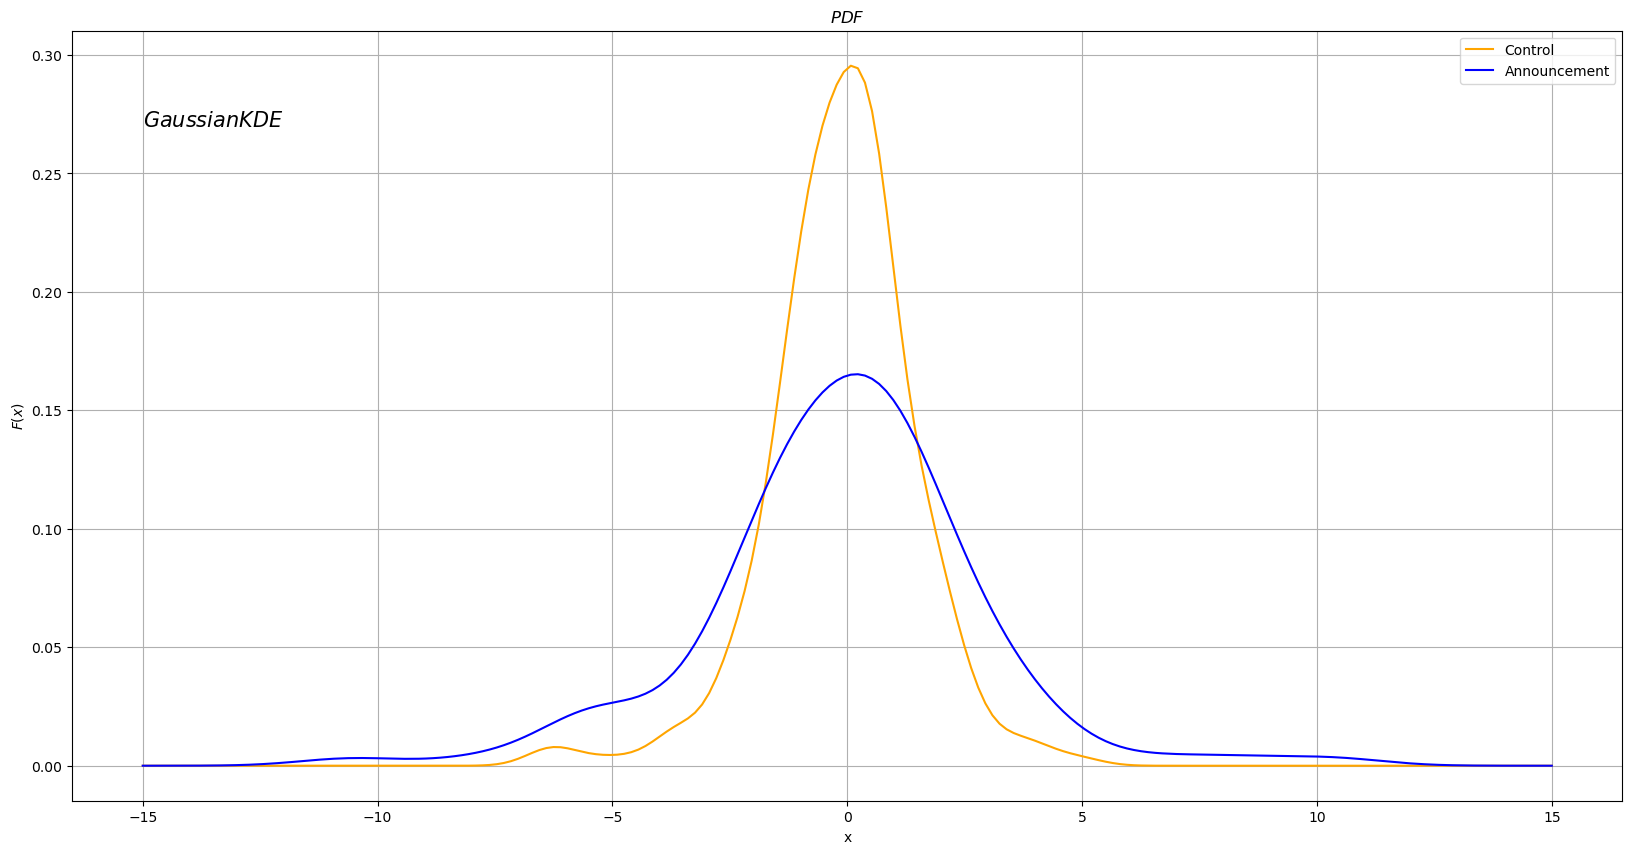

In [7]:
# Main data
OTDdata_values = OTDdata.pca_comp_1.values
PDdata_values = PDdata.pca_comp_1.values

# Create KDE objects
kde1 = scipy.stats.gaussian_kde(OTDdata_values)
kde2 = scipy.stats.gaussian_kde(PDdata_values)

# Evaluate KDE on a linspace
x_eval = np.linspace(-15, 15, num=200)

# Set figure size
rcParams['figure.figsize'] = 20, 10

plt.text(-15,0.27,'$Gaussian KDE$',fontsize = 15)

# Plot KDEs
plt.plot(x_eval, kde2(x_eval), 'orange', label='Control')
plt.plot(x_eval, kde1(x_eval), 'blue', label='Announcement')

# Calculate and print the probability for x > 1 for the Announcement KDE
probability_x_gt_1 = kde1.integrate_box_1d(1, np.inf)
print(f'Probability of x > 1 for Announcement KDE: {probability_x_gt_1:.4f}')

# Customize plot
plt.xlabel("x")
plt.ylabel(r'$F(x)$')
plt.title(r'$PDF$')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [8]:
# Extract dates and convert to datetime
dates = pd.to_datetime([x[0][0] for x in ODM['datesStringRaw']], format='%YM%m')

# Create a DataFrame directly from the dictionary
GENdata = pd.DataFrame({
    'CPI': ODM['CPI'][:, 0],
    'IP': ODM['IP'][:, 0],
    'OILPROD': ODM['OILPROD'][:, 0],
    'OILSTOCKS': ODM['OILSTOCKS'][:, 0],
    'POIL': ODM['POIL'][:, 0],
    'WORLDIP': ODM['WORLDIP'][:, 0]
}, index=dates)

# Concatenate the necessary DataFrames
Conc2 = pd.concat([OTDdata1, PDdata1]).loc[~pd.concat([OTDdata1, PDdata1]).index.duplicated()]
All = pd.concat([GENdata, Conc2], axis=1)
All

,CPI,IP,OILPROD,OILSTOCKS,POIL,WORLDIP,"DPL#(NCLC.02(PS),6)","DPL#(NCLC.03(PS),6)","DPL#(NCLC.04(PS),6)","DPL#(NCLC.05(PS),6)","DPL#(NCLC.06(PS),6)","DPL#(NCLC.07(PS),6)","DPL#(NCLC.08(PS),6)","DPL#(NCLC.09(PS),6)","DPL#(NCLC.10(PS),6)","DPL#(NCLC.11(PS),6)","DPL#(NCLC.12(PS),6)","DPL#(NCLC.13(PS),6)",pca_comp_1
1960-01-01,29.3700,25.0061,NaN,NaN,2.9700,20.1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,29.4100,24.7836,NaN,NaN,2.9700,20.1824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,29.4100,24.5611,NaN,NaN,2.9700,20.1925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-01,29.5400,24.3664,NaN,NaN,2.9700,20.1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-01,29.5700,24.3386,NaN,NaN,2.9700,20.2081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,245.2620,104.5605,80971.1300,2658.2270,48.0400,125.3369,3.0700,3.3930,3.6368,3.7615,3.8090,3.7981,3.7694,3.7424,3.7178,3.6523,3.5871,3.5420,3.9600
2017-09-01,246.3920,104.8687,81169.7500,2672.6468,49.8200,125.4106,-1.0738,-1.0313,-0.9912,-0.9905,-0.9717,-0.9728,-0.9745,-0.9767,-0.9597,-0.9614,-0.9437,-0.9449,-1.0787
2017-10-01,246.5830,106.5932,81391.6300,2621.8105,51.5800,125.6960,0.8168,0.7766,0.7372,0.6986,0.6609,0.6429,0.6064,0.5891,0.5716,0.5351,0.4982,0.4610,0.6795
2017-11-01,247.4110,106.8693,82043.8100,2622.6864,56.6400,126.7463,0.1568,0.1569,0.1398,0.1402,0.1233,0.1063,0.0891,0.0716,0.0360,-0.0181,0.0000,0.0000,0.0813


<Axes: >

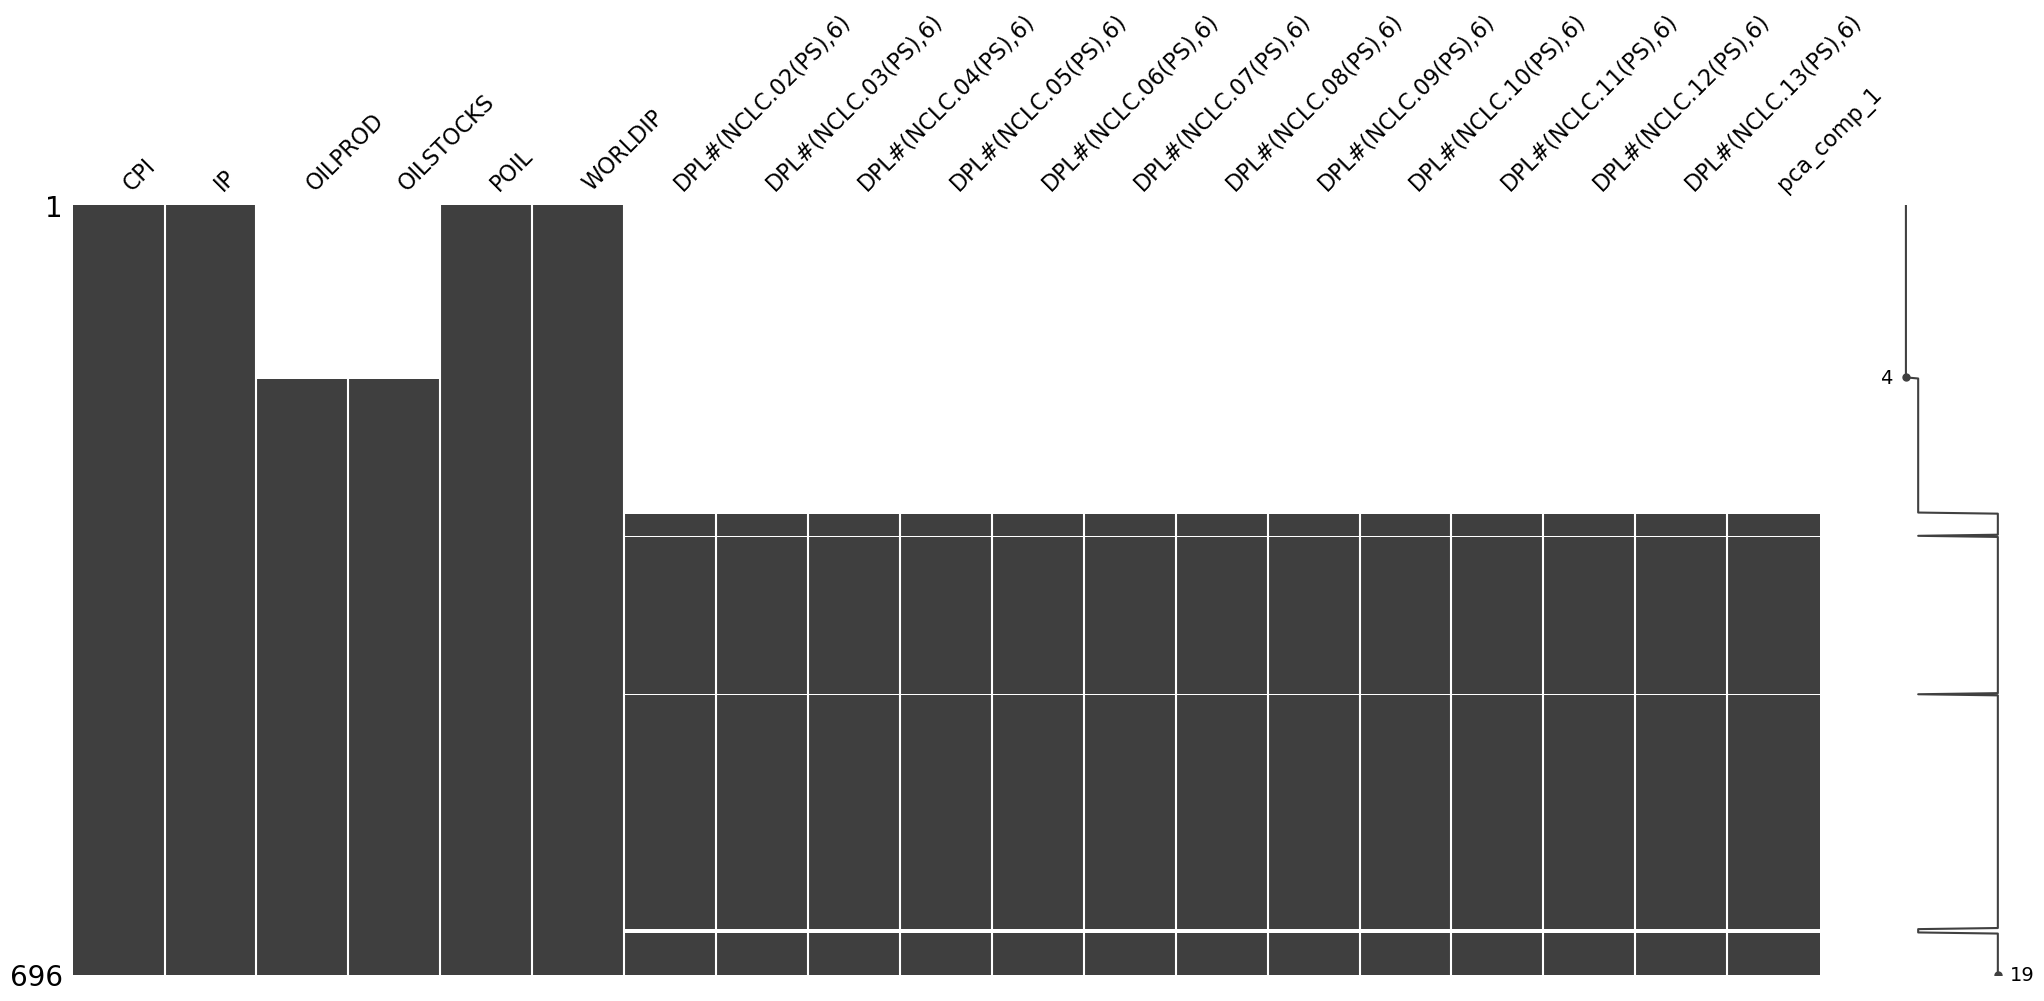

In [9]:
rcParams['figure.figsize'] = 15, 10

msno.matrix(All) 


In [10]:


# Combine GENdata and OTDdata1, drop NaN values
OTDin = pd.concat([GENdata, OTDdata1], axis=1).dropna()

# Filter All DataFrame based on date range and fill NaN values with 0
All = All['2017-12-12' >= All.index][All.index >= '1974-01-01'].fillna(0)

# Extract and reindex columns in All1
All1 = All.iloc[:, 0:6].reindex(columns=['POIL', 'CPI', 'IP', 'OILSTOCKS', 'OILPROD', 'WORLDIP'])

# Apply log transformation to selected columns and multiply by 100
log_transform_columns = ['OILPROD', 'OILSTOCKS', 'WORLDIP', 'CPI', 'IP']
All1[log_transform_columns] = np.log(All1[log_transform_columns]) * 100

# Retrieve 'POIL' column from GG DataFrame and assign it to All1
GG = pd.DataFrame(DBM['data'], columns=pd.DataFrame(DBM['varNames']).applymap(lambda x: x[0]).values[0])
All1['POIL'] = GG.iloc[:, 0].values

# Apply log transformation to 'IP' column and multiply by 100
All1

,POIL,CPI,IP,OILSTOCKS,OILPROD,WORLDIP
1974-01-01,307.2812,384.5883,385.2449,627.7492,1092.3670,378.7044
1974-02-01,306.2185,385.6510,384.9369,631.5714,1093.2089,378.2536
1974-03-01,305.1670,386.7026,384.9579,631.2601,1093.9781,378.1894
1974-04-01,304.5413,387.3282,384.6524,634.3549,1095.2735,378.2153
1974-05-01,303.5072,388.3624,385.4072,637.8878,1095.5689,378.7093
...,...,...,...,...,...,...
2017-08-01,297.4877,550.2327,464.9766,788.5415,1130.1848,483.1006
2017-09-01,300.6663,550.6924,465.2709,789.0825,1130.4298,483.1593
2017-10-01,304.0606,550.7699,466.9020,787.1620,1130.7028,483.3867
2017-11-01,313.0835,551.1051,467.1607,787.1954,1131.5009,484.2187


In [11]:
# Define constants
n = 6
nvar = 1
p = 24
alpha = 0.05

# Prepare the lagged regressors
X = All1.iloc[:, :n]
X = np.concatenate([X.shift(i) for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Prepare the endogenous variable and instrument
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = All1.iloc[p:, :n].values

# Perform OLS regression
ols_results = SVARIV.ols(Y, X)
eta = ols_results['errors']

# Calculate the F-statistic and p-value
F = np.var(eta.T[0], ddof=1) / np.var(Z, ddof=1)
p_value = scipy.stats.f.cdf(F, eta.T[0].size - 1, Z.size - 1)

# Display F-statistic and p-value
print(f'F-statistics: {F:.2f}\nP-value: {p_value:.2f}')

# Test Wald and Gamma_hat
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)
print('Gamma_hat estimated:')
print(Gamma_hat)
print(f'Wald estimated: {wald:.4f}')
print(f'Critical value (95%): {stats.chi2.ppf(0.95, df=1):.4f}')


F-statistics: 11.74
P-value: 1.00
Gamma_hat estimated:
[[ 2.84270223]
 [ 0.0418941 ]
 [-0.02355289]
 [-0.004494  ]
 [ 0.06497103]
 [ 0.00121083]]
Wald estimated: 22.7005
Critical value (95%): 3.8415


In [12]:
from linearmodels.iv import IV2SLS

res_ols = IV2SLS(eta.T[0], Z, None, None).fit(
    cov_type="robust"
)
print(res_ols)

                            OLS Estimation Summary                            
Dep. Variable:              dependent   R-squared:                      0.0645
Estimator:                        OLS   Adj. R-squared:                 0.0626
No. Observations:                 504   F-statistic:                    17.605
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        01:11:11   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           0.8690     0.2071     4.1958     0.0000      0.4631      1.2750


In [13]:
# Initialize empty lists to store results
n = 6
nvar = 1
p = 24
alpha = 0.05

# Prepare the lagged regressors
X = All1.iloc[:, :n]
X = np.concatenate([X.shift(i) for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Prepare the endogenous variable and instrument
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = All1.iloc[p:, :n].values

f_statistic_values = []
adjusted_r_squared_values = []

ols_results = SVARIV.ols(Y, X)
eta = ols_results['errors']


# Iterate over columns 6 to 18 in All DataFrame
for col in All.iloc[:, 6:19].columns:
    # Extract the relevant data for the current column
    Z1 = pd.DataFrame(All[col]).values[p:, :]
    
    # Perform IV2SLS regression
    res_ols = IV2SLS(eta.T[0], Z1, None, None).fit(cov_type="robust")
    
    # Append F-statistic and adjusted R-squared to the respective lists
    f_statistic_values.append([col, res_ols.f_statistic.stat])
    adjusted_r_squared_values.append(res_ols.rsquared_adj)

# Create a DataFrame from the collected results
result_table = pd.DataFrame(f_statistic_values)
result_table['$R^2$'] = adjusted_r_squared_values

# Define the column names for the result table
column_names = list(range(1, 13, 1))
column_names.append('pca_comp1')

# Transpose the result table, set clumn names, and drop unnecessary rows
result_table = result_table.T
result_table.columns = column_names
result_table = result_table.drop(0, axis=0)
result_table.index = ['F-stat (robust)', '$R^2$ adjusted']

# Display the result table
result_table


,1,2,3,4,5,6,7,8,9,10,11,12,pca_comp1
F-stat (robust),18.8502,19.0883,18.9416,18.5689,18.1514,18.0696,17.9681,18.0365,17.8379,17.0772,12.0580,10.4302,17.6050
$R^2$ adjusted,0.0679,0.0683,0.0675,0.0657,0.0638,0.0626,0.0616,0.0612,0.0597,0.0574,0.0418,0.0271,0.0626


In [14]:
result_table.to_latex()

'\\begin{tabular}{llllllllllllll}\n\\toprule\n{} &       1 &       2 &       3 &       4 &       5 &       6 &       7 &       8 &       9 &      10 &      11 &      12 & pca\\_comp1 \\\\\n\\midrule\nF-stat (robust) & 18.8502 & 19.0883 & 18.9416 & 18.5689 & 18.1514 & 18.0696 & 17.9681 & 18.0365 & 17.8379 & 17.0772 & 12.0580 & 10.4302 &   17.6050 \\\\\n\\$R\\textasciicircum 2\\$ adjusted  &  0.0679 &  0.0683 &  0.0675 &  0.0657 &  0.0638 &  0.0626 &  0.0616 &  0.0612 &  0.0597 &  0.0574 &  0.0418 &  0.0271 &    0.0626 \\\\\n\\bottomrule\n\\end{tabular}\n'

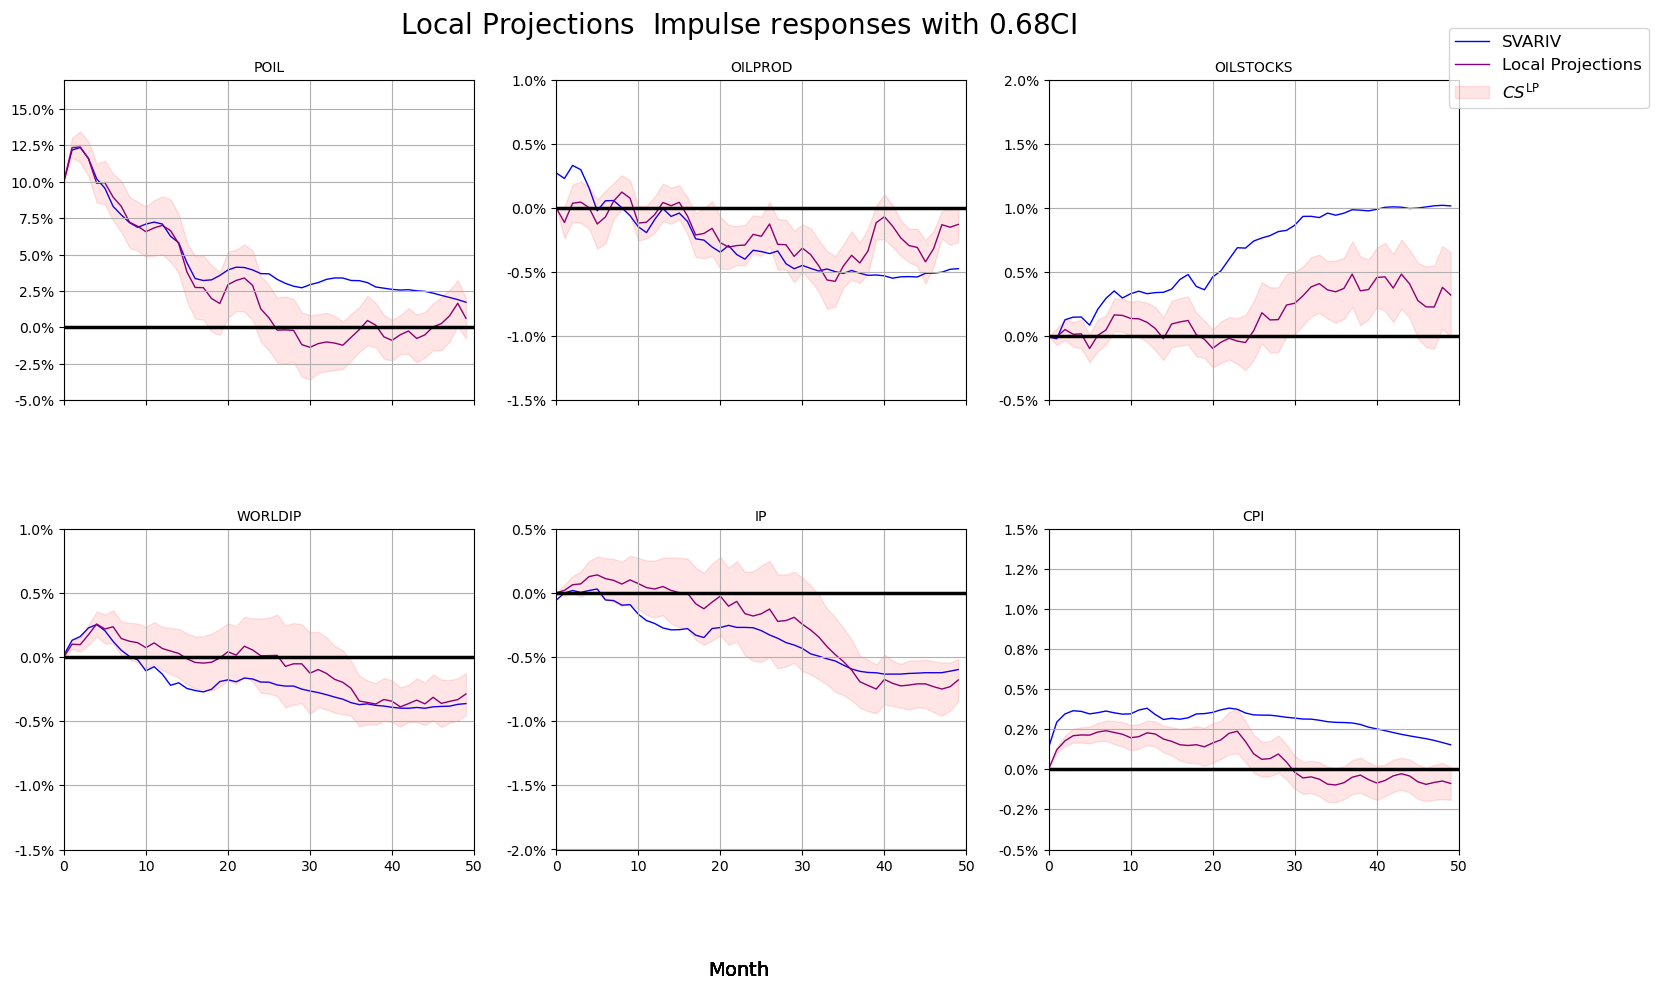

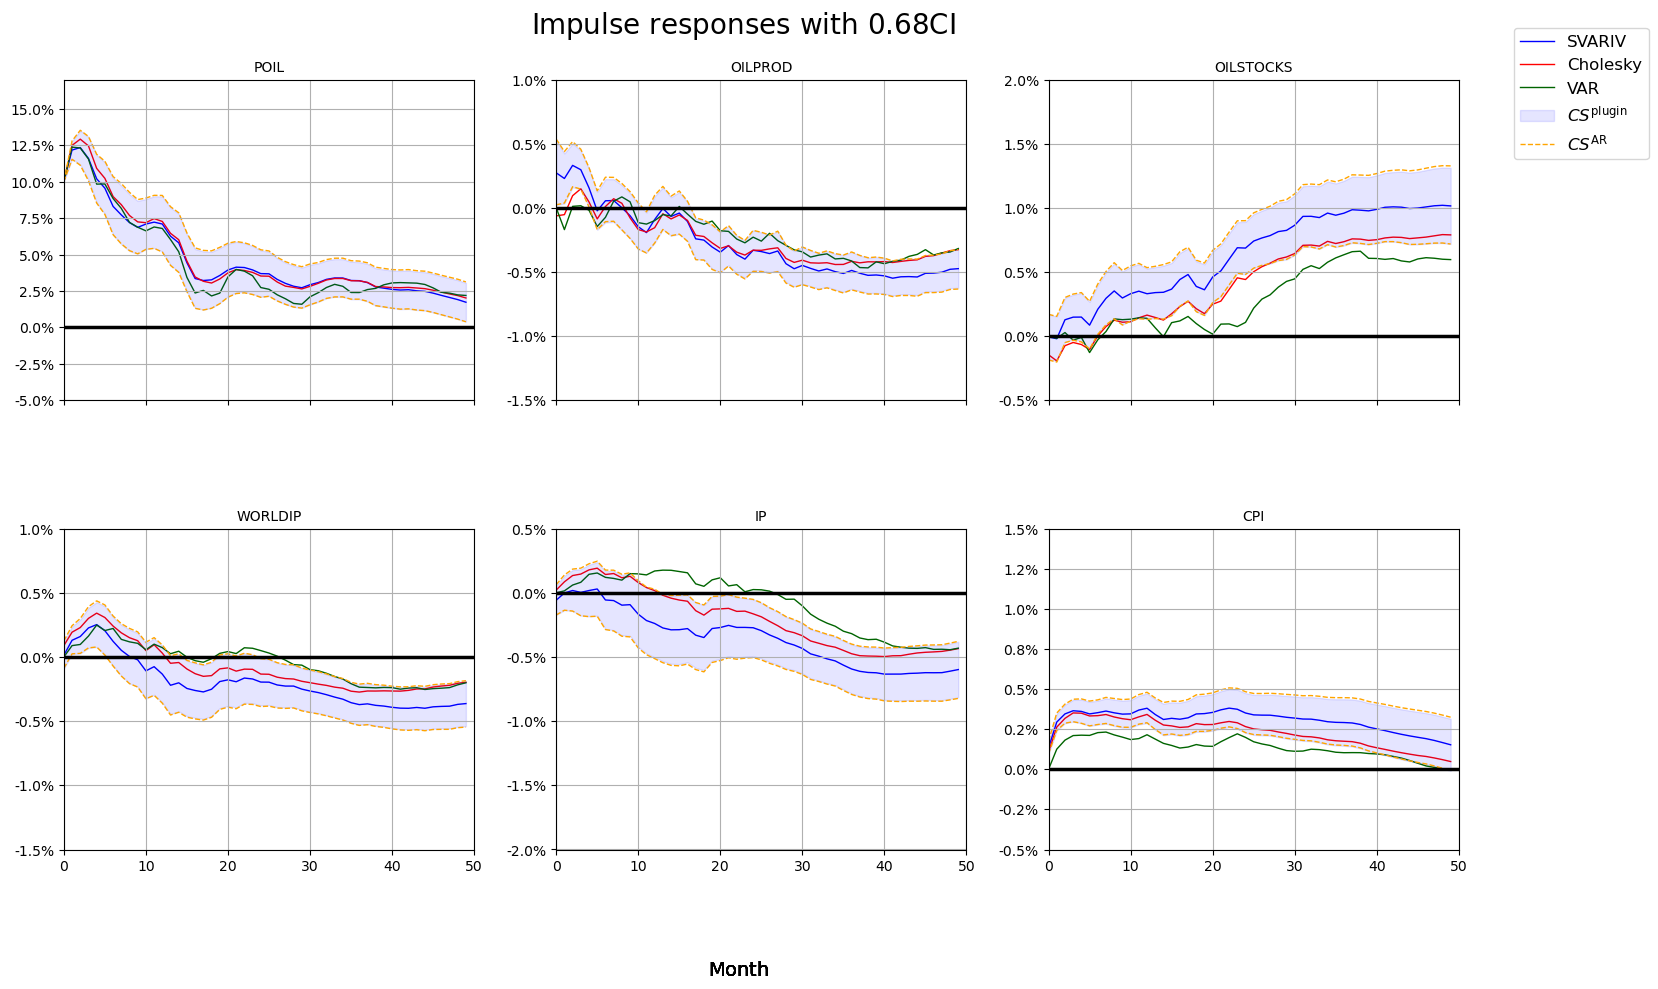

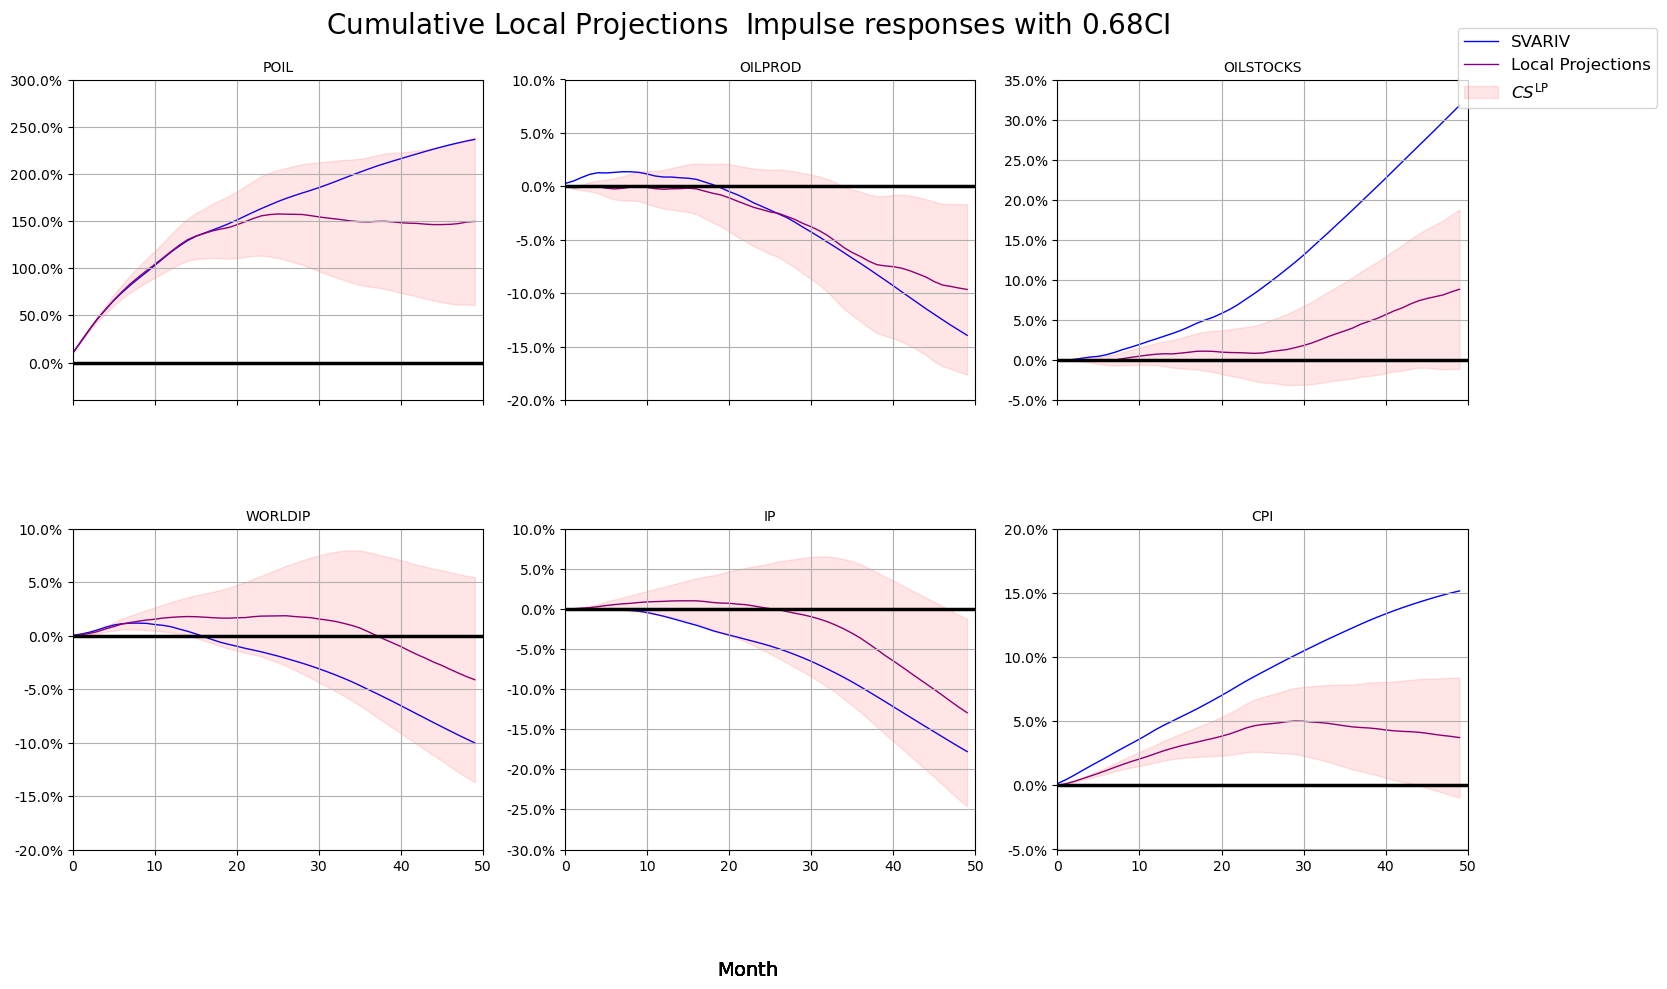

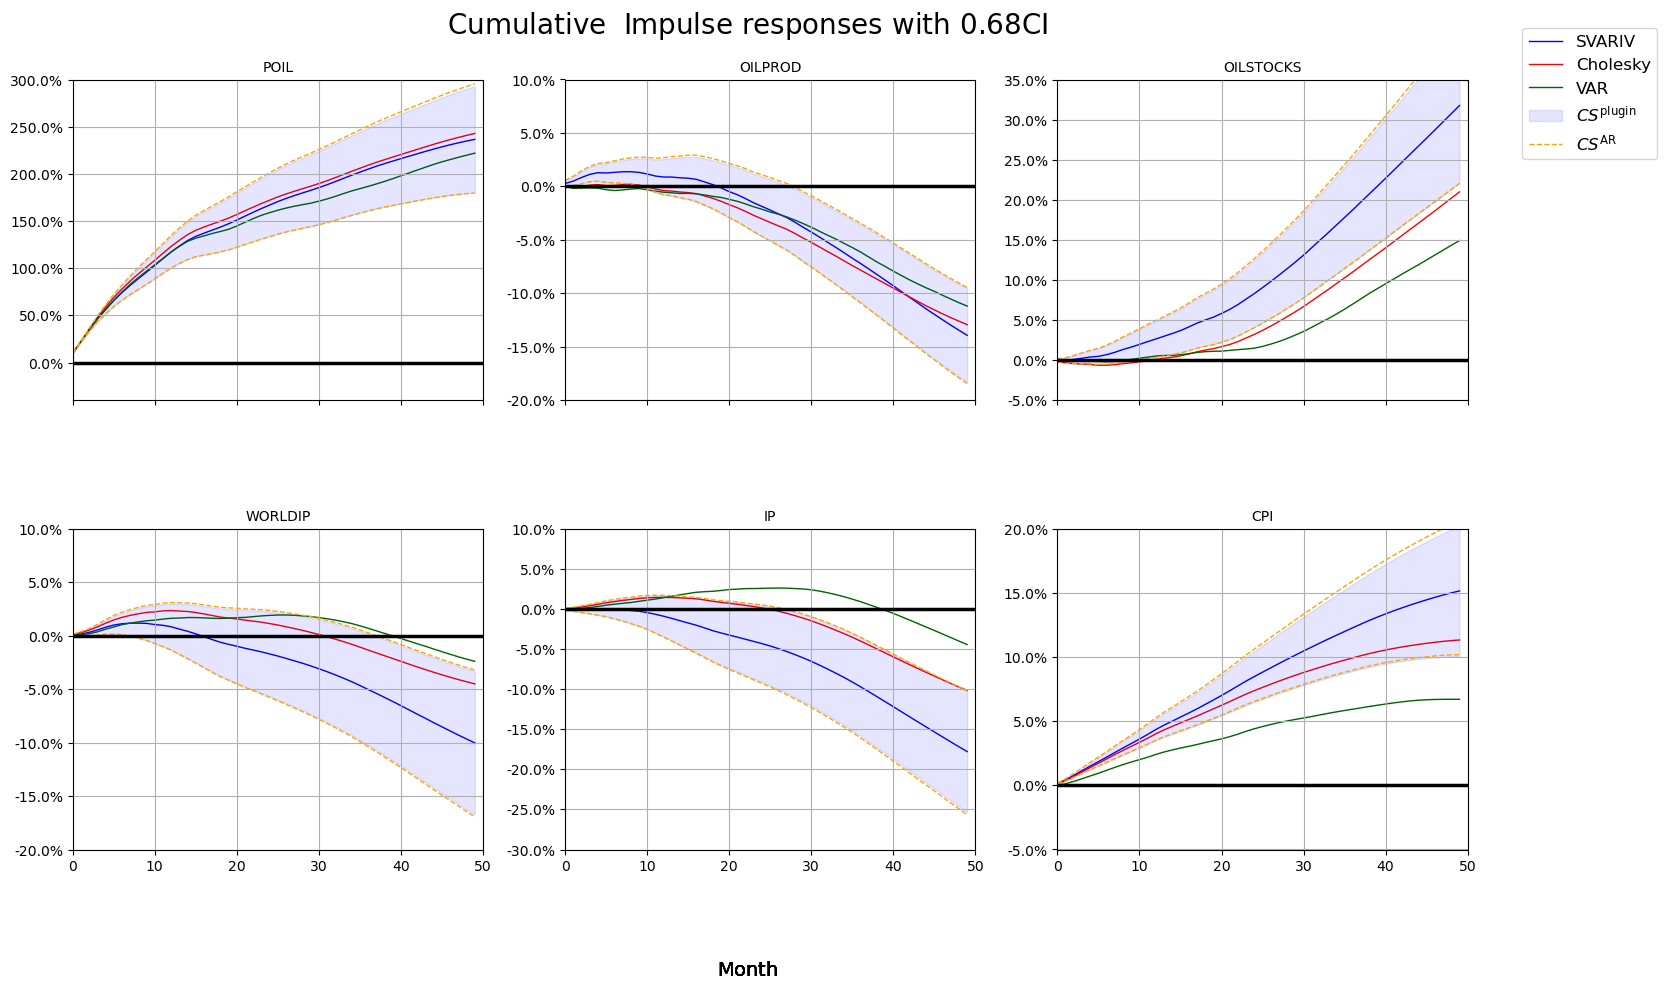

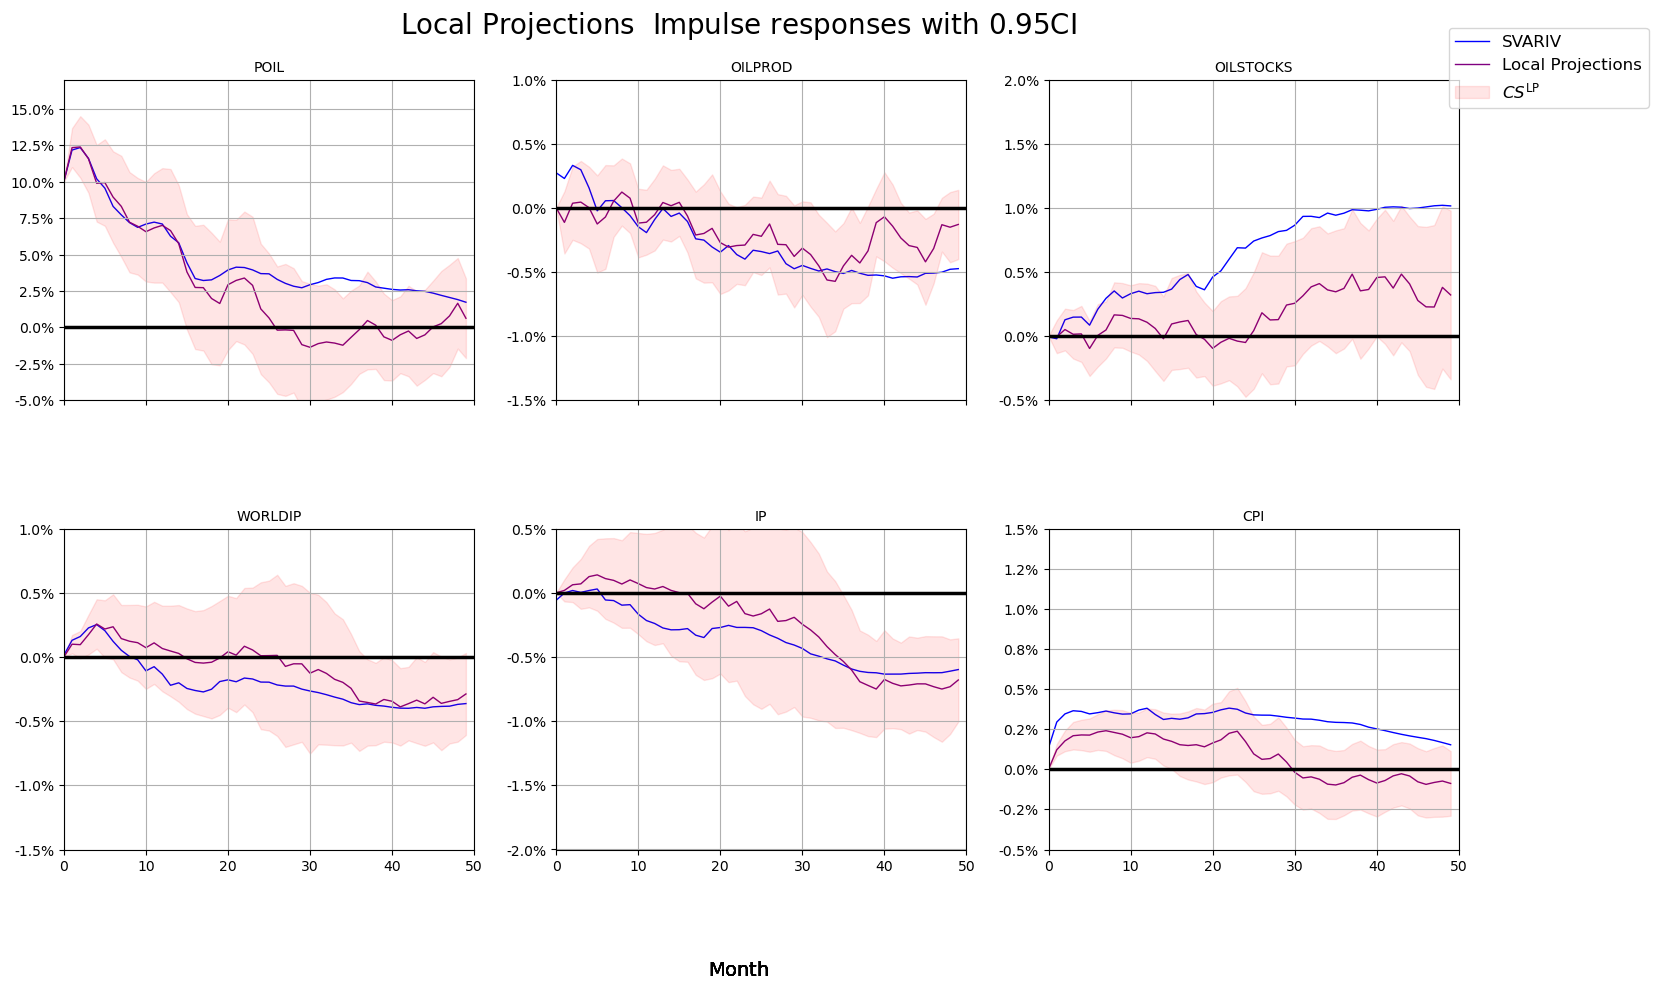

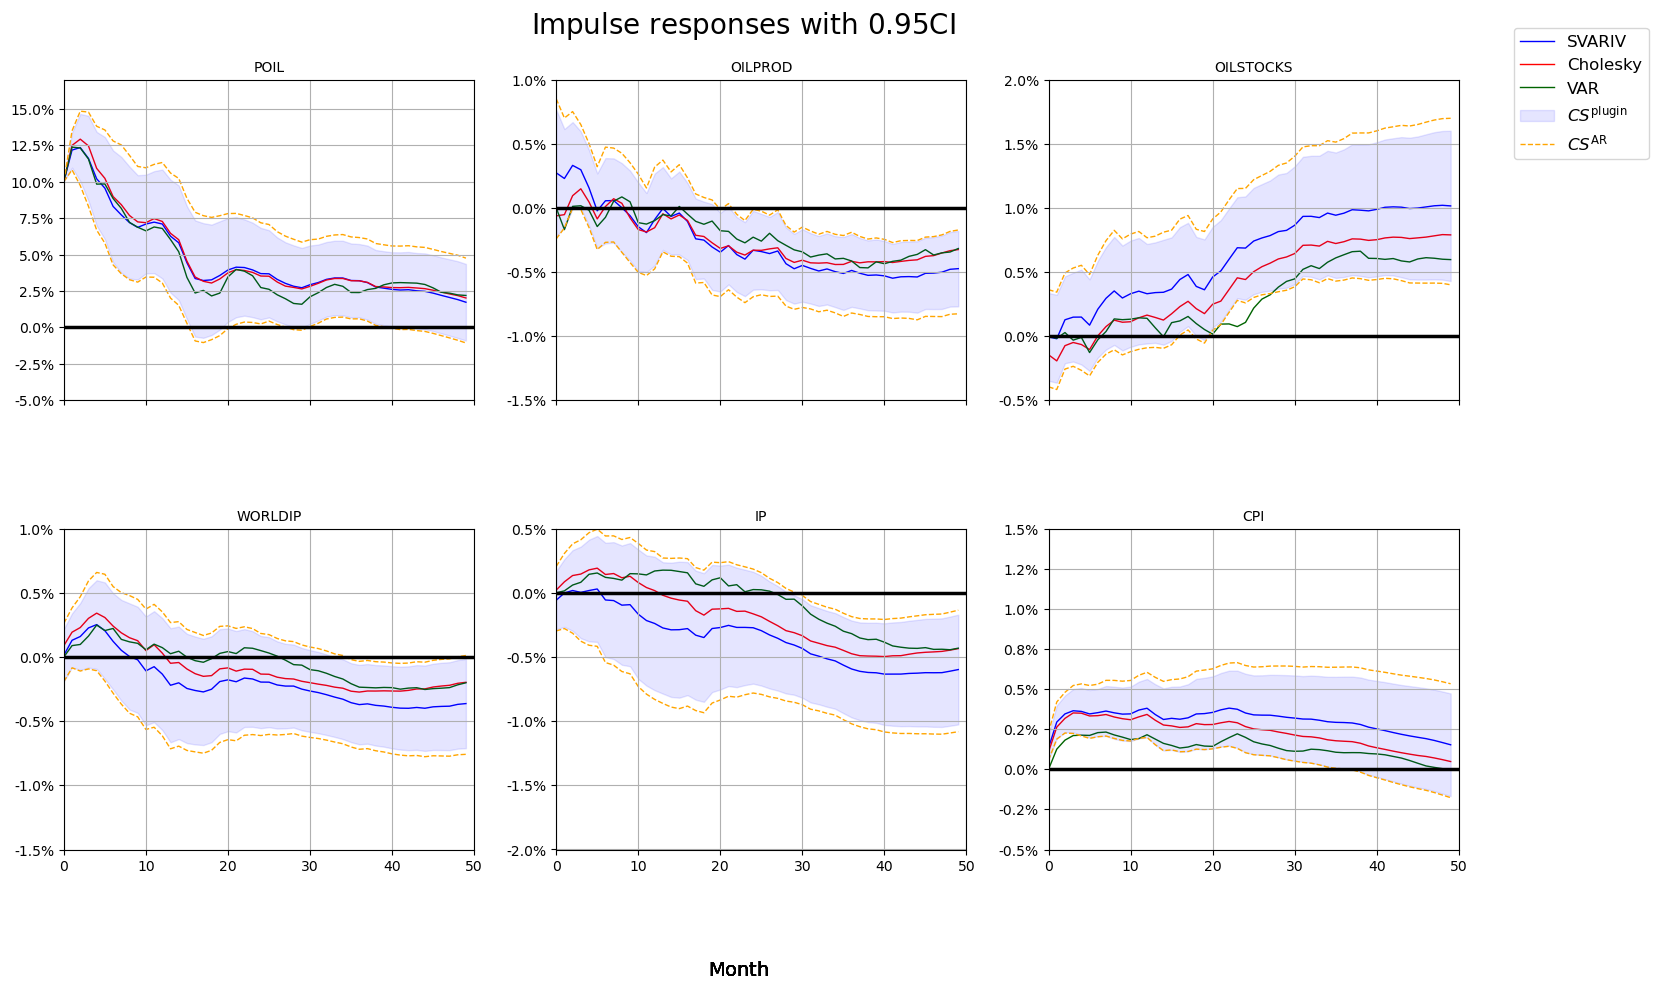

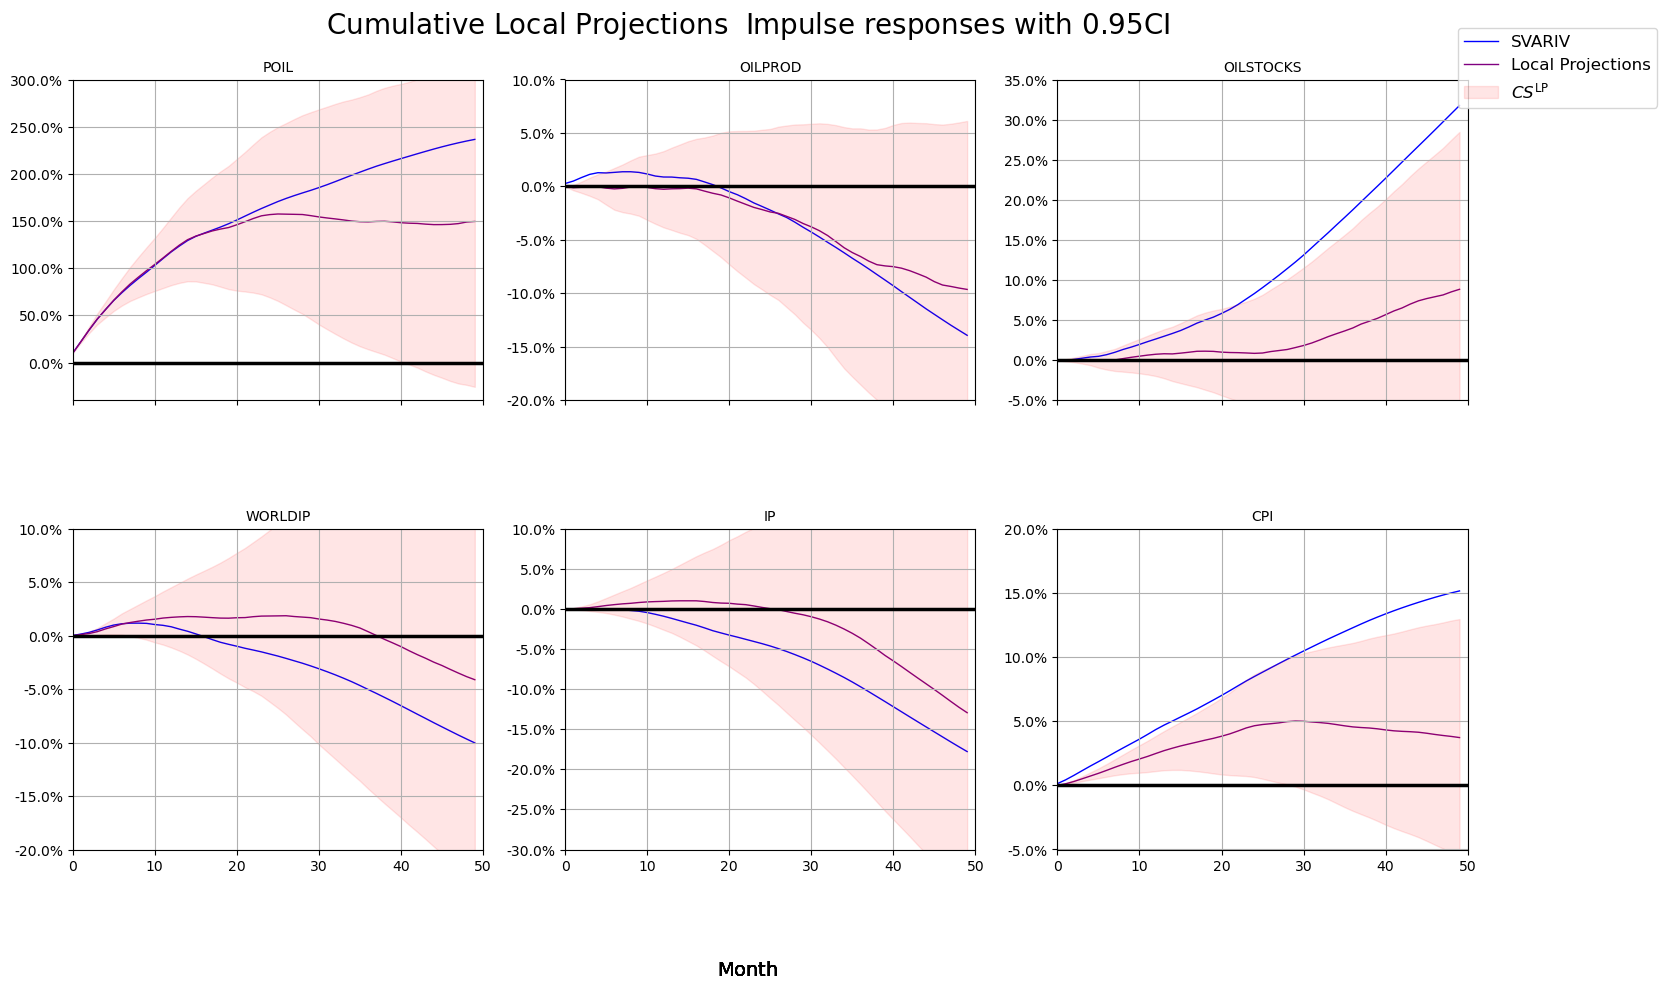

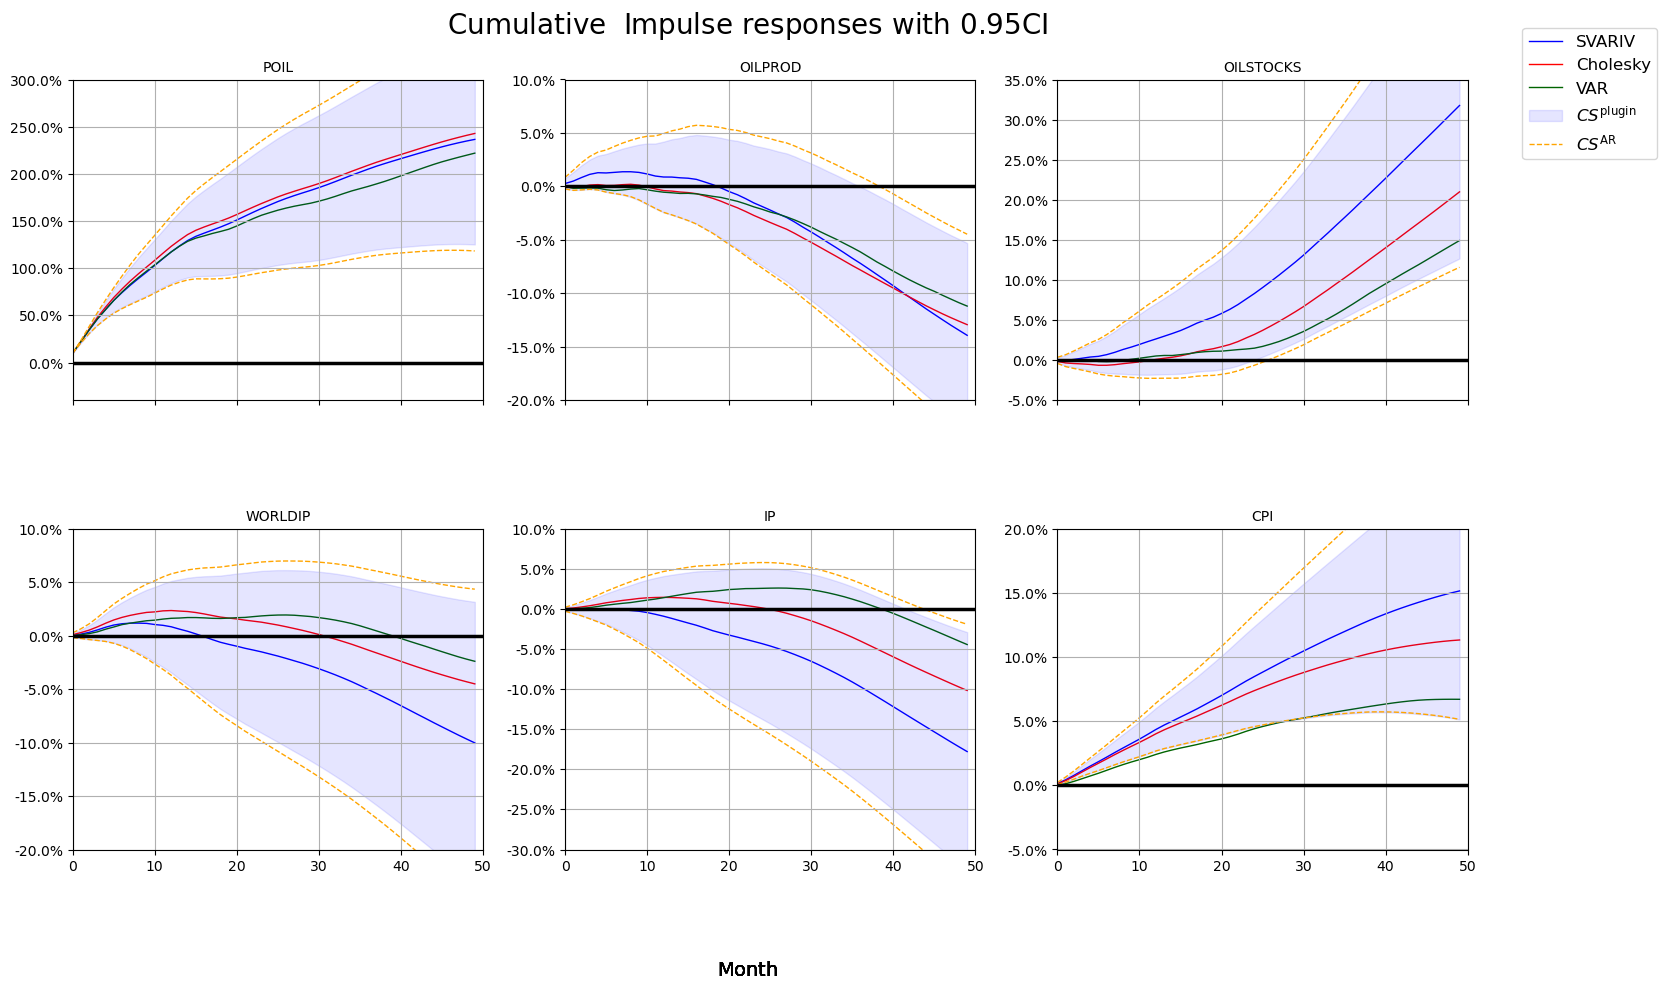

In [23]:
rot = 0
hori = 50
h=hori
p=20
legend = None


# Define the desired order of columns
desired_order = ['POIL', 'OILPROD', 'OILSTOCKS', 'WORLDIP', 'IP', 'CPI']
All1 = All1[desired_order]

# Prepare lagged input matrix X for SVAR model
X = (All1.iloc[:, 0:7])
X.columns = range(X.columns.size)
X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Extracting variables for SVAR analysis
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = pd.DataFrame(All1.iloc[:, 0:6]).values[p:, :]

# Estimate OLS residuals and perform SVAR analysis
ols_est = SVARIV.ols(Y, X)
eta = ols_est['errors']

# Set up SVAR parameters
nvar = 1
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

# Extract parameters for impulse response functions
betas = ols_est['betas_hat'].T
betas_lag = betas[:, 1:]
omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

# Compute impulse response functions for SVAR and Cholesky
irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h)
irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h)
irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False, periods=h)
irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True, periods=h)

# Fit VAR model for comparison
model = VAR(All1.dropna())
results = model.fit(24)
VAR1 = ((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1)

# Compute moving average representation matrices
C = SVARIV.MA_representation(betas_lag, p, hori=h)
Ccum = [np.array(C[:i + 1]).sum(axis=0) for i in range(len(C))]
G = SVARIV.Gmatrices(betas_lag, p, hori=h)['G']
Gcum = SVARIV.Gmatrices(betas_lag, p, hori=h)['Gcum']
T = len(Y)

# Set up plotting parameters
xticks = list(range(len(irf_gamma_cum)))

# Confidence Intervals and Cumulative options
conf_intervals = [0.68, 0.95]
Lp1 = [True, False]

cumulative_options = [False, True]

# Titles for each subplot
titles = desired_order

# Loop over confidence intervals and cumulative options
for ci_idx, ci in enumerate(conf_intervals):
    
    CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1)
    CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1)
    

    lpmdl = LP.LP(All1.reset_index(drop=True),maxlags=p,ci=ci)
    out, _ = lpmdl.estimate(hori,shock_size =0.1)
    # Select rows where impulse is 'POIL'
    poil_df = out.loc['POIL']

    # Reset the index to create a one-index DataFrame
    poil_df_reset = poil_df.reset_index()
    coef = pd.DataFrame()
    lb = pd.DataFrame()
    ub = pd.DataFrame()

    for colmn in All1.columns:
        coef[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['coef'].values[:-1]
        lb[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['lb'].values[:-1]
        ub[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['ub'].values[:-1]

    coef_cum=np.cumsum(coef)
    lb_cum=np.cumsum(lb)
    ub_cum=np.cumsum(ub)
    
    # Create a new figure for each combination
    for cum_idx, cum_opt in enumerate(cumulative_options):
        for lp_opt in (Lp1):
            
            fig, axs = plt.subplots(split_into_close_integers(len(All1.columns))[0],split_into_close_integers(len(All1.columns))[1], figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.4})
            axs_flat = axs.flatten()
        
            for i, ax in enumerate(axs_flat):
                title = titles[i]
                col = All1.columns[i]

                if i >= len(titles):
                    fig.delaxes(ax)  
                    continue

                # Set y-axis limits based on the column and cumulative option

                if cum_opt:
                    if col == 'POIL':
                        ylim1 = 3
                        ylim0 = -0.4
                    elif col == 'CPI':
                        ylim1 = 0.2
                        ylim0 = -0.05
                    elif col == 'WORLDIP':
                        ylim1 = 0.1
                        ylim0 = -0.2
                    elif col == 'IP':
                        ylim1 = 0.1
                        ylim0 = -0.3
                    elif col == 'OILSTOCKS':
                        ylim1 = 0.35
                        ylim0 = -0.05
                    elif col == 'OILPROD':
                        ylim1 = 0.1
                        ylim0 = -0.2
                else:
                    if col == 'POIL':
                        ylim1 = 0.17
                        ylim0 = -0.05
                    elif col == 'CPI':
                        ylim1 = 0.015
                        ylim0 = -0.005
                    elif col == 'WORLDIP':
                        ylim1 = 0.01
                        ylim0 = -0.015
                    elif col == 'IP':
                        ylim1 = 0.005
                        ylim0 = -0.02
                    elif col == 'OILSTOCKS':
                        ylim1 = 0.02
                        ylim0 = -0.005
                    elif col == 'OILPROD':
                        ylim1 = 0.01
                        ylim0 = -0.015


                # Select the appropriate impulse response functions and confidence intervals
                if cum_opt:
                    plugin_cs = np.array([irf_gamma_cum[:, i] + SVARIV.norm_critval(confidence=ci) * CI_s_cum['pluginirfstderror'][i, :],
                                          irf_gamma_cum[:, i] - SVARIV.norm_critval(confidence=ci) * CI_s_cum['pluginirfstderror'][i, :]]).T
                else:
                    plugin_cs = np.array([irf_gamma[:, i] + SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][i, :],
                                          irf_gamma[:, i] - SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][i, :]]).T

                low_plugin = plugin_cs[:, 0]
                upp_plugin = plugin_cs[:, 1]



                # Calculate VAR impulse response for comparison
                VAR_P = np.cumsum(((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1).iloc[i]).values[:-1] if cum_opt else \
                        (((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1).iloc[i]).values[:-1]
                if lp_opt:
                    # Plotting
                    ax.set_title(f'{title}', fontsize=10)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, label='SVARIV')
                    ax.plot(coef_cum.values[:, i] if cum_opt else coef.values[:, i], color='purple', zorder=1, linewidth=1, label='Local Projections')
                    ax.fill_between(xticks, lb_cum.values[:, i]  if cum_opt else lb.values[:, i] , ub_cum.values[:, i] \
                                    if cum_opt else ub.values[:, i], color='r', alpha=.1, label=r'$CS^{\mathrm{LP}}$')

                    ax.grid()
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                else: 
                    ax.set_title(f'{title}', fontsize=10)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, label='SVARIV')
                    ax.plot(irf_chol_cum[:, i] if cum_opt else irf_chol[:, i], color='red', zorder=1, linewidth=1, label='Cholesky')
                    ax.plot(VAR_P, color='darkgreen', zorder=1, linewidth=1, label='VAR')
                    ax.fill_between(xticks, low_plugin, upp_plugin, color='b', alpha=.1, label=r'$CS^{\mathrm{plugin}}$')
                    ax.plot(CI_cum['l'][i, :] if cum_opt else CI['l'][i, :], '--', zorder=1, linewidth=1, color='orange', label=r'$CS^{\mathrm{AR}}$')
                    ax.plot(CI_cum['u'][i, :] if cum_opt else CI['u'][i, :], '--', zorder=1, linewidth=1, color='orange')                 
                    ax.grid()
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                fig.text(0.5, -0.01, r'$\mathrm{Month}$', ha='center', va='center', fontsize=14)

                # Add 'Cumulative' to suptitle only for cumulative options
                suptitle_str1 = 'Cumulative ' if cum_opt else '' 
                suptitle_str2= 'Local Projections ' if lp_opt else ''
                fig.suptitle(suptitle_str1+suptitle_str2 + r'$\mathrm{\ Impulse\ responses\ with\ ' + str(ci) + ' CI}$', fontsize=20, y=0.95)

            # Place the legend outside of the subplots
            handles, labels = axs_flat[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 0.94), fontsize=12)

            # Save the figure with a unique name based on CI and cumulative options
            saved = f'./IRF_pdfs/IRF{ci}_Cumulative_{cum_opt}_LP_{lp_opt}.pdf'
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            plt.savefig(saved, bbox_inches='tight')
            plt.show()        
plt.close("all")



In [16]:
for lp_idx, lp_opt in enumerate(Lp1):
    print(lp_opt)

True
False
